In [1]:
import gym
import pygame
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pdb
import time
from IPython.display import clear_output
import random

random.seed(42)

### Environment characteristics:

The environment is taken from the OpenAI Gym library. Its layout includes the game **Frozen Lake**, which is an associative problem.
\
\
The aim of this game is to cross a frozen lake, starting from an initial position, S, to an end position, G, by walking across the frozen lake, F, which is safe, without falling into the hole, H.

##### Action Space

The agent can do **4** possible actions, navigate **left**, **right**, **up** and **down**. The game ends when the agent reaches the goal or fall in a hole.\
\
The agent takes one element vector action per time.

##### State Space

The state space is defined by a value which rappresent the agent current position, and it is calculeted as: *current row + current columns*. The state space size is 16 because the environment is a 4x4 grid.

##### Reward Schedule

The reward can be 0 or 1. If the agent reaches the goal, G, the reward is equal to 1, otherwise is 0.

In [2]:
env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery = False)#, render_mode="human")
print(env.reset()[0])
print(f'State Space: {env.observation_space}')
print(f'Action Space: {env.action_space}')
action_space = env.action_space.n
state_space = env.observation_space.n

0
State Space: Discrete(16)
Action Space: Discrete(4)


In [3]:
print(env.step(0))

(0, 0.0, False, False, {'prob': 1.0})


c:\Users\lucam\anaconda3\envs\rl_frozenlake\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [4]:
#env.render()

In [5]:
random.seed(42)

### 1) Random Policy

First, it is decided to apply a model involving the implementation of a random policy to solve the Frozen Lake game.\
In this case, the actions chosen by the agent are totally random without the implementation of any learning structure.

In [6]:
class Random_policy_agent:
    def __init__(self, env):
        self.env = env
        self.comul_rewards = []

    def train(self, episodes=2000):
        for _ in range(episodes):
            state = self.env.reset()
            done = False
            total_reward_episode = 0
            while not done:
                action = self.env.action_space.sample()
                next_state, reward, done, info, _ = self.env.step(action)
                total_reward_episode += reward
                state = next_state
            self.comul_rewards.append(total_reward_episode)
            print(f"episode: {_}/{episodes}, return: {total_reward_episode}")

In [7]:
rand_agent = Random_policy_agent(env)

In [8]:
rand_agent.train()

episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob': 1.0}/2000, return: 0.0
episode: {'prob'

In [9]:
print(f"Average return over 2000 episodes: {sum(rand_agent.comul_rewards)/2000}")

Average return over 2000 episodes: 0.0135


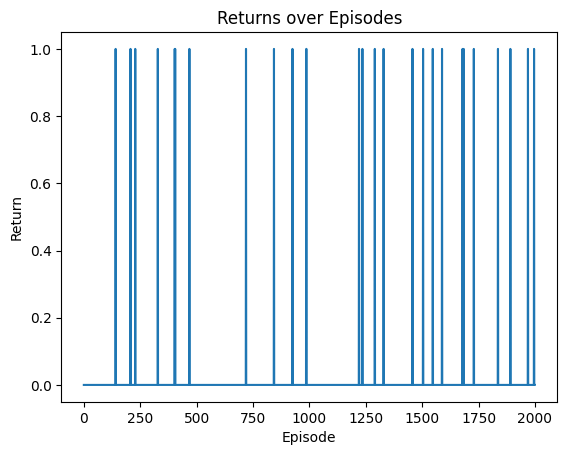

In [10]:
plt.plot(rand_agent.comul_rewards)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

As was to be expected, the model comes to completion in a totally random manner, and in particular the achievement of the target, G, is assumed on only among the 1% of the attempts.

### 2) Monte Carlo model

Monte Carlo is a model-free method, i.e. a procedure for learning the optimal state value function. It does not require or assume a priori information on the transition probabilities of states (the environment dynamics).
\
The state value function is thus estimated using only experience, and in particular represents a mathematical expectation of the returns obtained from each particular state s and each time step t.

**The main objective of the MC methods** is to run many episodes taking into account the corrisponding state trajectory and obtained rewards. On the basis of these informations, the MC methods will approximate the state value function as the average value of the expected future returns obtain in the current state in random episodes.\
\
The Expected return at a particular time t, is defined as the weighted sum of the obtained rewards, weigthed by the discount rate (if the discount rate is equal to 1, it will be a simple sum).

An **episode** is a sequence of states, actions and rewards obtained by following a certain policy. More specifically, it represents sub-sequences of agent-environment interactions whose terminal state is always the same, but which may show different rewards.

In this case, a **first-visit Monte Carlo method** is followed, in which the estimation and improvement of the state-action value function, Q(s,a), are given considering only the first visit to each state.

In order to ensure exploration, and thus provide a better estimate of the value function of the action-state, the **epsilon soft greedy** policy is provided, which then allows to maintain exploration.

In the **learn** function, one can see the presence of an iterative update of the function Q(s,a) which moves forward the optimal value. This type of update used is called *constant alpha MC*, and it is defined as:\
**V(st) = V(St) + alpha * [Gt - V(St)]**

In [11]:
class Monte_carlo_agent:
    def __init__(self, env, discount_rate, epsilon, epsilon_min, epsilon_decay):
        self.env = env
        
        self.discount_rate = discount_rate
        
        self.epsilon = epsilon
        
        self.epsilon_decay = epsilon_decay
        
        self.epsilon_min = epsilon_min
        
        self.actions = self.env.action_space
        
        self.q_value_table = self.initialize_q_values() 
        
        self.returns = {}  # Stores the returns for each state-action pair
        # no need for a policy table, since the actions are taken greedily from Q
        self.returns_count = {} # Counts the occurrence of each state-action pair

        # Store the cumulative reward of each episode
        self.cumulative_returns = []
    
    def initialize_q_values(self):
        # Initialize q value function for all states-action pair
        values = np.zeros([self.env.observation_space.n,self.env.action_space.n]) # attention: should be float
        return values
        
        
    def get_epsilon_greedy_action(self, state):
        if random.random() >= self.epsilon:
            action = np.argmax(self.q_value_table[state,:])
            return action # Action made is the one with the highest q value for the current state
        else: 
            action = self.env.action_space.sample() # Action made randomly
            return action
        
    def learn(self, episode):
        state_visited = set()
        rewards = [x[2] for x in episode]
        Gt = 0
        for i in range(len(episode)-1,-1,-1): # from the last visited state we go backwards
            state, action, reward = episode[i]
            state_action = (state, action)

            # Check if the state visited is the first time visted or not
            if state_action not in state_visited: # if it is visited for the first time
                state_visited.add(state_action)

                # Compute the return
                Gt = self.discount_rate * Gt + reward

                if state_action not in self.returns:
                    self.returns[state_action] = [Gt]  # Initialize if first visit in all episodes
                    self.returns_count[state_action] = 1
                else:
                    self.returns_count[state_action] += 1  # Increment the count that state action pair is visited
                    self.returns[state_action].append(Gt) # Keep for potential analysis

            # Incremental update formula
                alpha = 1.0 / self.returns_count[state_action]
                self.q_value_table[state_action] += alpha * (Gt - self.q_value_table[state_action])
            
    def generate_episode(self):
        trajectory = []
        total_reward = 0
        state = self.env.reset()[0] # Reset environment for a new episode
        done = False
        while True:
            action = self.get_epsilon_greedy_action(state)
            next_state, reward, done, info, _ = self.env.step(action)
            trajectory.append((state, action, reward))
            state = next_state
            total_reward += reward
            if done:
                break
        return (trajectory, total_reward)

    def train(self, episodes):

        for episode in range(1, episodes + 1):
            
            # Update epsilon with decay, but not less than its minimum values
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            # Generate episode and learn from it
            trajectory, total_reward = self.generate_episode()
            self.learn(trajectory)
            print(f"episode: {episode}/{episodes}, return: {total_reward}, epsilon: {self.epsilon:.2f}")


            # Plot the collected cumulative reward
            self.cumulative_returns.append(sum([t[2] for t in trajectory]))
            
    def get_value_table(self):
        value_table = np.max(self.q_value_table, axis=1)
        print(value_table)
        return value_table
    
    
    def test(self, episodes):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False, render_mode='human')
        total_rewards = []  # To track rewards over episodes
        
        for episode in range(1, episodes + 1):
            state = env.reset()[0]  # Initialize to state 0
            done = False     
            total_reward = 0
            while True:
                action = np.argmax(self.q_value_table[state,:])
                next_state, reward, done, info, _ = env.step(action)
                state = next_state
                total_reward += reward
                env.render()
                if done: # If done is True break the episode (we get a H or G)
                    break

            total_rewards.append(total_reward)
            print(f"Episode {episode}: Total Reward: {total_reward}")

        print(f"Average return over {episodes} episodes: {sum(total_rewards)/episodes}")

        return total_rewards
    

In [12]:
discount_rate = 0.9
epsilon_decay = 0.998
epsilon = 1
epsilon_min = 0.1

In [13]:
mc_agent = Monte_carlo_agent(env, discount_rate, epsilon, epsilon_min, epsilon_decay) 
mc_agent.train(2000)
mc_agent.get_value_table
print(f'Average return: {np.mean(mc_agent.cumulative_returns)}')

episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.0, epsilon: 0.96
episode: 23/2000, r

Through the use of the Monte Carlo approach, it is possible to observe an attainment of the target, G, in a good amount of the cases. A much better percentage than with the random policy model

Moreover, it is possible to observe the **Q table** estimated by the model:

In [17]:
mc_agent.q_value_table


array([[0.19338817, 0.40482009, 0.12233881, 0.18328636],
       [0.19122831, 0.        , 0.03715913, 0.04825007],
       [0.03970645, 0.06184979, 0.04025008, 0.09607684],
       [0.05869803, 0.        , 0.        , 0.        ],
       [0.25684315, 0.50454561, 0.        , 0.21847555],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.24232289, 0.        , 0.05864261],
       [0.        , 0.        , 0.        , 0.        ],
       [0.32846006, 0.        , 0.61327722, 0.27941435],
       [0.34339832, 0.74182772, 0.57975858, 0.        ],
       [0.35280147, 0.84198745, 0.        , 0.13293904],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.68797829, 0.87585536, 0.50368398],
       [0.67502136, 0.84946834, 1.        , 0.63260517],
       [0.        , 0.        , 0.        , 0.        ]])

In this table, it is possible to observe the various states in the rows and the various actions in the columns. The present values define the q-value associated with each state and action pair.

Consequently, the **Q(S,A) optimal function** obtained can be observed:

In [18]:
mc_agent.get_value_table()

[0.40482009 0.19122831 0.09607684 0.05869803 0.50454561 0.
 0.24232289 0.         0.61327722 0.74182772 0.84198745 0.
 0.         0.87585536 1.         0.        ]


array([0.40482009, 0.19122831, 0.09607684, 0.05869803, 0.50454561,
       0.        , 0.24232289, 0.        , 0.61327722, 0.74182772,
       0.84198745, 0.        , 0.        , 0.87585536, 1.        ,
       0.        ])

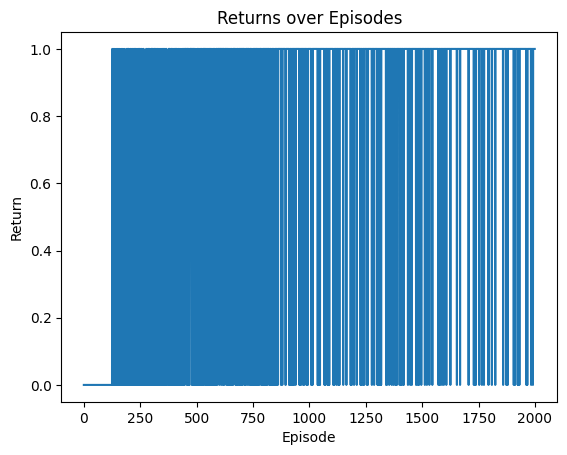

In [19]:
plt.plot(mc_agent.cumulative_returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

Also in this case, it is possible to observe the graph concerning the total rewards obtained in each episode.
In particular, it can be noted that the MC method after an initial exploratory section only reaches the optimal policy after the 1000 episodes, guaranteeing to always reach the target.

#### Test

In [20]:
mc_agent.test(10)

c:\Users\lucam\anaconda3\envs\rl_frozenlake\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward: 1.0
Episode 2: Total Reward: 1.0
Episode 3: Total Reward: 1.0
Episode 4: Total Reward: 1.0
Episode 5: Total Reward: 1.0
Episode 6: Total Reward: 1.0
Episode 7: Total Reward: 1.0
Episode 8: Total Reward: 1.0
Episode 9: Total Reward: 1.0
Episode 10: Total Reward: 1.0
Average return over 10 episodes: 1.0


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### 3) Q-learning

Q-learning is **temporal differential learning**, the main idea of which is to combine Monte Carlo concepts, the learning by direct interaction with the environment, with dynamic programming, the update of the value estimate on the basis of other estimates.

Compared to the Monte Carlo approach, the TD does not need to wait until the end of the episode to obtain Gt (the discounted future reward of a state at time t), but only requires information about the next time step. Thus, these algorithms turn out to be more efficient and faster in converging.\
Compared to dynamic programming, time difference methods have the advantage that they do not require a model of the environment as they are off policy algorithms.

In particular the iterative updating of the value function is defined as:\
**Q(St, A) = Q(St, A) + Learning rate * [Rt+1 + gamma*max[Q(St+1, A)] - Q(St, A)]**\
[Rt+1 + gamma*V(St+1) - V(St)] is called Temporal Difference Error.

In [21]:
class Q_learning_agent:
    def __init__(self, env, lr, gamma, epsilon, min_epsilon, max_epsilon):
        self.env = env
        
        self.lr = lr
        
        self.gamma = gamma
        
        # Initial values for alpha and epsilon
        self.epsilon = epsilon
        
        # Minimum values for alpha and epsilon
        self.min_epsilon = min_epsilon
        self.max_epsilon = max_epsilon
        
        self.q_value_table = self.initialize_q_values() 

        # no need for a policy table, since the actions are taken greedily from Q

        # Initialize list for storing cumulative returns for plotting purposes
        self.cumulative_returns = []
        
    def initialize_q_values(self):
        # Initialize q value function for all states-action pair
        values = np.zeros([self.env.observation_space.n,self.env.action_space.n]) # attention: should be float
        return values
        
        
    def get_epsilon_greedy_action(self, state):
        if random.random() > self.epsilon:
            action = np.argmax(self.q_value_table[state,:])
            return action # Action made is the one with the highest q value for the current state
        else: 
            action = self.env.action_space.sample() # Action made randomly
            return action
        
    def learn(self, state, action, reward, new_state):
        old_value = self.q_value_table[state, action] # Old Q-table value
        next_max = np.max(self.q_value_table[new_state,:]) # learned value

        # Q-learning Formula to update the q-values of the q-table
        self.q_value_table[state, action] = old_value + self.lr*(reward + (self.gamma*next_max) - old_value)

        
    def train(self, Total_episodes, decay_rate, max_steps):

        for episode in range(Total_episodes): # for any episode
            
            state = self.env.reset()[0] # we reset any time the environment

            step = 0
            done = False  # done define when the current episode end
            total_reward = 0

            for step in range(max_steps): #for the max number of step used in one episode
                action = self.get_epsilon_greedy_action(state)
                new_state, reward, done, info, _ = self.env.step(action) # we pass the action to the environment and we get some values

                self.learn(state, action, reward, new_state)
                
                total_reward += reward

                state = new_state

                if done: # If done is True break the episode (we get a H or G)
                    print(f"episode: {episode}/{Total_episodes}, return: {total_reward}, epsilon: {self.epsilon:.2f}")
                    break

            # update the epsilon
            self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon)*np.exp(-decay_rate*episode)

            self.cumulative_returns.append(total_reward)
            
    def test(self, episodes, max_steps):
                
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=False, render_mode='human')

        total_rewards = []  # To track rewards over episodes
        
        for i in range(1, episodes+1):
            state = env.reset()[0]  # Initialize to state 0
            done = False     
            total_reward = 0  # To track total reward per episode            

            # Agent navigates map until it falls into a hole (done), reaches goal (done), or has taken 200 actions (stop).
            for step in range(max_steps): #for the max number of step used in one episode
                action = np.argmax(self.q_value_table[state,:])
                new_state, reward, done, info, _ = env.step(action) # we pass the action to the environment and we get some values
                
                total_reward += reward

                state = new_state

                if done: # If done is True break the episode (we get a H or G)
                    break

            total_rewards.append(total_reward)
            print(f"Episode {i}: Total Reward: {total_reward}")

        env.close()

        print(f"Average return over {episodes} episodes: {sum(total_rewards)/episodes}")

        return total_rewards
    
    

In [22]:
Total_episodes = 2000 # number of times the game is played
lr = 0.2 # Learning rate (higher it is and more importance to the new value and we never converge)
max_steps = 100 # max number of steps in each episodes (if the agent doesn't go in H or G)
gamma = 0.99 # Gamma is a discount factor

epsilon = 1 # define the times in which we want to explore or exploite the table (epsilon = 1 --> maximum exploration)
max_epsilon = 1
min_epsilon = 0.1
decay_rate= 0.001 # rate of decay --> the rate of decreasing of the epsilon which will lead to make more exploitation than exploration with respect the starting point

In [23]:
q_learning_agent = Q_learning_agent(env, lr, gamma, epsilon, min_epsilon, max_epsilon) 
q_learning_agent.train(Total_episodes, decay_rate, max_steps)
print(f'Average return: {sum(q_learning_agent.cumulative_returns)/Total_episodes}')

episode: 0/2000, return: 0.0, epsilon: 1.00
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 1.00
episode: 4/2000, return: 0.0, epsilon: 1.00
episode: 5/2000, return: 0.0, epsilon: 1.00
episode: 6/2000, return: 0.0, epsilon: 1.00
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.99
episode: 9/2000, return: 0.0, epsilon: 0.99
episode: 10/2000, return: 0.0, epsilon: 0.99
episode: 11/2000, return: 0.0, epsilon: 0.99
episode: 12/2000, return: 0.0, epsilon: 0.99
episode: 13/2000, return: 0.0, epsilon: 0.99
episode: 14/2000, return: 0.0, epsilon: 0.99
episode: 15/2000, return: 0.0, epsilon: 0.99
episode: 16/2000, return: 0.0, epsilon: 0.99
episode: 17/2000, return: 0.0, epsilon: 0.99
episode: 18/2000, return: 0.0, epsilon: 0.98
episode: 19/2000, return: 0.0, epsilon: 0.98
episode: 20/2000, return: 0.0, epsilon: 0.98
episode: 21/2000, return: 0.0, epsilon: 0.98
episode: 22/2000, re

With regard to the Q-learning model, a higher percentage of successful attempts can be observed compared to the MC model.\
From the plot below, it is also possible to note a more rapid learning of the Q(S;A) function and thus the faster attainment of the optimal policy, as was predicted theoretically.

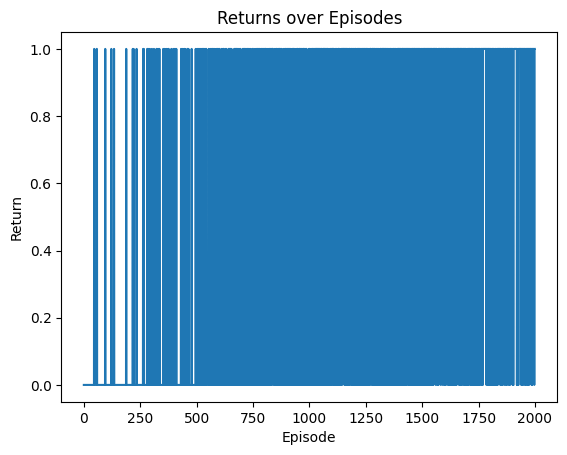

In [24]:
plt.plot(q_learning_agent.cumulative_returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

Using a Q-learning algorithm, the output of the training is the Q-table that is completly fulfill by all the values for each state-action conbination. From this table is possible to understand all the action the agent will provide in each possible state, which will be the one with the highest q-value.\
**Q-Table :**

In [25]:
q_learning_agent.q_value_table

array([[0.94148015, 0.93206535, 0.95099005, 0.94148015],
       [0.94148015, 0.        , 0.96059601, 0.95099005],
       [0.95099005, 0.970299  , 0.95099005, 0.96059601],
       [0.96059601, 0.        , 0.95075324, 0.95091147],
       [0.93206438, 0.92247654, 0.        , 0.94148015],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9801    , 0.        , 0.96059601],
       [0.        , 0.        , 0.        , 0.        ],
       [0.77579459, 0.        , 0.92538886, 0.93204298],
       [0.91191469, 0.96374156, 0.9801    , 0.        ],
       [0.970299  , 0.99      , 0.        , 0.970299  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.93469342, 0.99      , 0.9585919 ],
       [0.9801    , 0.99      , 1.        , 0.9801    ],
       [0.        , 0.        , 0.        , 0.        ]])

#### Test

In [26]:
q_learning_agent.test(10,200)

Episode 1: Total Reward: 1.0
Episode 2: Total Reward: 1.0
Episode 3: Total Reward: 1.0
Episode 4: Total Reward: 1.0
Episode 5: Total Reward: 1.0
Episode 6: Total Reward: 1.0
Episode 7: Total Reward: 1.0
Episode 8: Total Reward: 1.0
Episode 9: Total Reward: 1.0
Episode 10: Total Reward: 1.0
Average return over 10 episodes: 1.0


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### 4) Deep Q-Learning

The Deep Q Network is a combination between the Q-learning apporach and a Deep Neural Network for the Q-function approximation.\
In particular, in Q-learning the Q-function is modeled as a parametric function whose weights are updated by interacting with the environment. Instead, in the DQN the Q-function is approximate trought the use of a Deep Neural Network.\
\
In the DQN, the updating formula change a little bit with respect the Q-learning:
* q[state,action] = reward                                          **(if new_state is the terminal state)**
* q[state,action] = reward + discount_factor * max(q[new_state,:])  **(if new_state is not the terminal state)**

More explicitly, the **Deep Q Network** is composed of a regular Feed Forward Neural Network, where the input layer is defined by a number of nodes equal to the space of states, **16**, and the output layer has a number of nodes equal to the space of actions, **4**.\
\
When the agent is in a particular state, only the node associated with that state is equal to 1, all others are set equal to 0.\
The output will consist of the 4 q-values associated with all actions in that particular state. The best action in a state will be the one with the highest q-value.

The activation functions are the ReLU functions in both the hidden and output layers.

2 DQNetworks will be provided, the first one called **policy network** is used to implement the training part, the second Network is called **Target Network** which is the one that employs the DQN formula and in which we implement the policy network set up in the first DQN.

To avoid algorithm divergence, **experience replay** is implemented, which reduces the correlation between samples.

##### Define the DQN structure

In [27]:
# Build the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os

dir = "trained_agents"
if not os.path.exists(dir):
    os.makedirs(dir)

class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_dim)
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)
    
    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)  
    
    def __len__(self):
        return len(self.memory)


In [29]:
class FrozenLake():
    # Hyperparameters
    lr = 0.003  # Learning rate
    epsilon_rate = 1.0  # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9  # Discount factor
    update_rate = 10  # Update target network every 10 episodes
    replay_memory_size = 1000  # Replay memory size
    batch_size = 64  # Number of samples to take from replay memory
    checkpoint_episode = 200  # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U']  # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQNetwork(states, actions)
        target_net = DQNetwork(states, actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes + 1)

        epsilon_rate_history = []
        returns = []  # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes + 1):  # Loop through episodes
            state = env.reset()[0]
            done = False  # True if agent stepped on a hole or reached the goal
            stop = False  # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad():  # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state, states)).argmax().item()

                new_state, reward, done, _, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward)  # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size)  # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net)  # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"trained_agents/policy_net{episode}.pth")

        env.close()
        return returns

    def optimize(self, batch, policy_net, target_net):
        states = policy_net.fc1.in_features
        current_q_list = []
        target_q_list = []

        for state, action, reward, new_state, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state, states)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state, states))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state, states))
            # Adjust the specific action to the target that was just calculated.
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state: int, states: int) -> torch.Tensor:
        # One hot encode the state
        state_onehot = torch.zeros(states)
        state_onehot[state] = 1
        return state_onehot

    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_net = DQNetwork(num_states, num_actions)
        policy_net.load_state_dict(torch.load("trained_agents/policy_net2000.pth"))
        policy_net.eval()  # switch model to evaluation mode

        for i in range(1, episodes + 1):
            state = env.reset()[0]  # Initialize to state 0
            done = False  # True when agent falls in hole or reached goal
            stop = False  # True when agent takes more than 200 actions
            print(f"Episode {i}/{episodes}")

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not done and not stop:
                # Select best action
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state, num_states)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)

                if reward == 1:
                    print("Goal reached!")
        

        env.close()


##### Train the DQN

Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

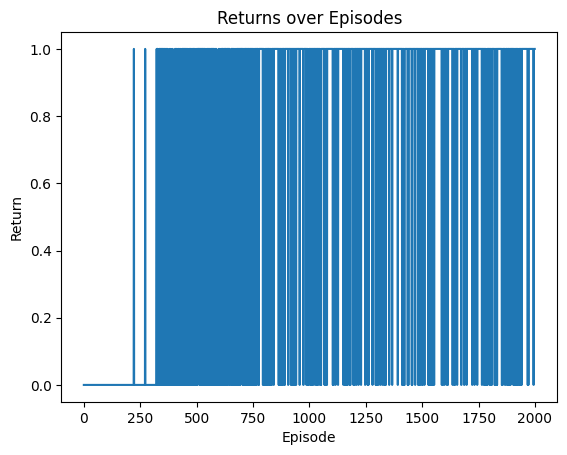

Rate of success:  0.64


In [30]:
# Train the model and get returns
fl = FrozenLake()
returns = fl.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

print("Rate of success: ", sum(returns)/len(returns))

With regard to the DQN model, may be observe an almost immediate learning of the Q(S,A) function that quickly reaches an optimal policy, faster even than Q-learning.\
On the other hand, a problem is observed in the learning of subsequent episodes which tend to forget the previous training process, this is due to the size of the **Replay Memory**.

##### Evaluate the Model

In [31]:
# Test the model
fl.test(episodes=10, render=True, is_slippery=False)

Episode 1/10
Goal reached!
Episode 2/10
Goal reached!
Episode 3/10
Goal reached!
Episode 4/10
Goal reached!
Episode 5/10
Goal reached!
Episode 6/10
Goal reached!
Episode 7/10
Goal reached!
Episode 8/10
Goal reached!
Episode 9/10
Goal reached!
Episode 10/10
Goal reached!


Overall, the DQN is able to reach the target almost 80 per cent of the time, far better than Q-learning and Monte Carlo methods.

# FrozenLake using a CNN

In this part we implement a CNN to train the agent in the same environment in a way similar to the original paper of DQN. We provide a detailed overview of each function:

- The DQCNN class is the definition of the CNN model. It has two convolutional blocks, each with two convolutional layers followed by a ReLU activation function and a max pooling layer. The output of the convolutional blocks is flattened and passed through a linear layer to produce the output.

- The FrozenLake_CNN class is the main class for training and testing the agent in the FrozenLake environment. It has several hyperparameters defined, such as learning rate, epsilon rate for epsilon-greedy policy, discount factor, and others.

- The train method is used to train the agent. It initializes the environment, the replay memory, and two instances of the CNN model (policy network and target network). It then loops through a specified number of episodes, in each episode, it selects an action based on the epsilon-greedy policy, executes the action, and stores the transition in the replay memory. If the replay memory is large enough, it samples a batch of transitions and optimizes the policy network.

- The optimize method is used to optimize the policy network. It calculates the target Q-values and the current Q-values, computes the loss between them, and performs backpropagation and optimization.

- The state_to_dqn_input method is used to convert the state into a suitable format for the CNN input. It converts the state into a 4x4 grid with the agent's position marked in a specific color.

- The test method is used to test the trained agent. It loads the trained policy network and uses it to select actions in a number of episodes. It prints a message when the agent reaches the goal.

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import gymnasium as gym
import os
import math

# Define model
class DQCNN(nn.Module):
    def __init__(self, input_shape, out_actions):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into a single vector
            # After flattening the matrix into a vector, pass it to the output layer. To determine the input shape, use the print() statement in forward()
            nn.Linear(in_features=10*1*1, out_features=out_actions)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        # print(x.shape)  # Use this to determine input shape of the output layer.
        x = self.layer_stack(x)
        return x


In [33]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

In [34]:
class FrozenLake_CNN():
    # Hyperparameters
    lr = 0.003  # Learning rate
    epsilon_rate = 1.0  # Exploration rate
    epsilon_min = 0.1
    epsilon_decay = 0.998
    gamma = 0.9  # Discount factor
    update_rate = 10  # Update target network every 10 episodes
    replay_memory_size = 1000  # Replay memory size
    batch_size = 64  # Number of samples to take from replay memory
    checkpoint_episode = 200  # Save model checkpoint every 100 episodes

    ACTIONS = ['L', 'D', 'R', 'U']  # Left, Down, Right, Up

    def train(self, episodes, render=False, is_slippery=False):
        env = gym.make('FrozenLake-v1', map_name='4x4', is_slippery=is_slippery, render_mode='human' if render else None)
        states = env.observation_space.n
        actions = env.action_space.n

        memory = ReplayMemory(self.replay_memory_size)

        policy_net = DQCNN(input_shape=3, out_actions=actions)
        target_net = DQCNN(input_shape=3, out_actions=actions)

        target_net.load_state_dict(policy_net.state_dict())

        print('Training on', 'slippery' if is_slippery else 'non-slippery', 'FrozenLake')

        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(policy_net.parameters(), lr=self.lr)

        rewards_per_episode = np.zeros(episodes + 1)

        epsilon_rate_history = []
        returns = []  # List to store returns for each episode

        steps = 0

        for episode in range(1, episodes + 1):  # Loop through episodes
            state = env.reset()[0]
            done = False  # True if agent stepped on a hole or reached the goal
            stop = False  # True if agent takes too long to solve the environment
            total_reward = 0

            while not done and not stop:
                # Epsilon_rate-greedy policy
                if random.random() < self.epsilon_rate:
                    # take a random action
                    action = env.action_space.sample()
                else:
                    # take the action with the highest Q-value
                    with torch.no_grad():  # Disable gradient tracking since we are not training
                        action = policy_net(self.state_to_dqn_input(state)).argmax().item()

                new_state, reward, done, _, _ = env.step(action)
                memory.append((state, action, reward, new_state, done))

                state = new_state
                total_reward += reward
                steps += 1

            rewards_per_episode[episode] = total_reward
            returns.append(total_reward)  # Track the return

            if len(memory) >= self.batch_size and np.sum(rewards_per_episode) > 0:
                batch = memory.sample(self.batch_size)  # Sample a batch of transitions
                self.optimize(batch, policy_net, target_net)  # Optimize the policy network passing the batch

            if self.epsilon_rate > self.epsilon_min:
                self.epsilon_rate *= self.epsilon_decay
                epsilon_rate_history.append(self.epsilon_rate)

                if steps > self.update_rate:
                    target_net.load_state_dict(policy_net.state_dict())
                    steps = 0

            if done:
                print(f"episode: {episode}/{episodes}, return: {rewards_per_episode[episode]}, epsilon: {self.epsilon_rate:.2f}")

            if episode % self.checkpoint_episode == 0:
                torch.save(policy_net.state_dict(), f"trained_agents/policy_net_CNN_{episode}.pth")

        env.close()

    def optimize(self, batch, policy_net, target_net):
        states = policy_net.conv_block1[0].in_channels
        current_q_list = []
        target_q_list = []

        for state, action, reward, new_state, done in batch:
            if done:
                # If the episode is done, the target is the reward (0 if the agent fell in a hole, 1 if it reached the goal)
                target = torch.FloatTensor([reward])
            else:
                # Calculate target q value
                with torch.no_grad():
                    target = torch.FloatTensor(
                        reward + self.gamma * target_net(self.state_to_dqn_input(new_state)).max()
                    )

            # Get the current set of Q values
            current_q = policy_net(self.state_to_dqn_input(state))
            current_q_list.append(current_q)

            # Get the target set of Q values
            target_q = target_net(self.state_to_dqn_input(state))
            # Adjust the specific action to the target that was just calculated.
            # Target_q[batch][action], hardcode batch to 0 because there is only 1 batch.
            target_q[0][action] = target
            target_q_list.append(target_q)

        # Compute loss for the whole minibatch
        loss = self.loss_fn(torch.stack(current_q_list), torch.stack(target_q_list))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def state_to_dqn_input(self, state:int)->torch.Tensor:
        '''
        Converts a state (int) to a tensor representation for input into CNN: tensor[batch][channel][row][column].
        The FrozenLake 4x4 map has 4x4=16 states numbered from 0 to 15. 
        Example:
        Input: state=1
        Return: tensor([[[[0., .9, 0., 0.],
                        [0., 0., 0., 0.],
                        [0., 0., 0., 0.],
                        [0., 0., 0., 0.]],
                        repeat above matrix 2 more times
                                        ]])
            where .9 is the normalize color code of Red
        '''
        # create empty tensor[batch][channel][row][column].
        # Converting 1 state, so batch is always 1.
        # Channels = 3, Red Green Blue (RGB).
        # FrozenLake map has 4 rows x 4 columns.
        input_tensor = torch.zeros(1,3,4,4)

        # convert state to row and column
        r=math.floor(state/4)
        c=state-r*4

        # Set color for each channel. Normalize it. The color selected here is (R,G,B) = (245,66,120)
        input_tensor[0][0][r][c] = 245/255
        input_tensor[0][1][r][c] = 66/255
        input_tensor[0][2][r][c] = 120/255
        
        return input_tensor


    def test(self, episodes, render=True, is_slippery=False):
        # Create FrozenLake instance
        env = gym.make('FrozenLake-v1', map_name="4x4", is_slippery=is_slippery, render_mode='human')
        num_states = env.observation_space.n
        num_actions = env.action_space.n

        # Load learned policy
        policy_net = DQCNN(input_shape=3, out_actions=num_actions)
        policy_net.load_state_dict(torch.load("trained_agents/policy_net_CNN_2000.pth"))
        policy_net.eval()  # switch model to evaluation mode

        for i in range(1, episodes + 1):
            state = env.reset()[0]  # Initialize to state 0
            done = False  # True when agent falls in hole or reached goal
            stop = False  # True when agent takes more than 200 actions
            print(f"Episode {i}/{episodes}")

            # Agent navigates map until it falls into a hole (terminated), reaches goal (terminated), or has taken 200 actions (truncated).
            while not done and not stop:
                # Select best action
                with torch.no_grad():
                    action = policy_net(self.state_to_dqn_input(state)).argmax().item()

                # Execute action
                state, reward, done, stop, _ = env.step(action)

                if reward == 1:
                    print("Goal reached!")
        

        env.close()

### Training

Here we define an 

In [35]:
f1 = FrozenLake_CNN()

Training on non-slippery FrozenLake
episode: 1/2000, return: 0.0, epsilon: 1.00
episode: 2/2000, return: 0.0, epsilon: 1.00
episode: 3/2000, return: 0.0, epsilon: 0.99
episode: 4/2000, return: 0.0, epsilon: 0.99
episode: 5/2000, return: 0.0, epsilon: 0.99
episode: 6/2000, return: 0.0, epsilon: 0.99
episode: 7/2000, return: 0.0, epsilon: 0.99
episode: 8/2000, return: 0.0, epsilon: 0.98
episode: 9/2000, return: 0.0, epsilon: 0.98
episode: 10/2000, return: 0.0, epsilon: 0.98
episode: 11/2000, return: 0.0, epsilon: 0.98
episode: 12/2000, return: 0.0, epsilon: 0.98
episode: 13/2000, return: 0.0, epsilon: 0.97
episode: 14/2000, return: 0.0, epsilon: 0.97
episode: 15/2000, return: 0.0, epsilon: 0.97
episode: 16/2000, return: 0.0, epsilon: 0.97
episode: 17/2000, return: 0.0, epsilon: 0.97
episode: 18/2000, return: 0.0, epsilon: 0.96
episode: 19/2000, return: 0.0, epsilon: 0.96
episode: 20/2000, return: 0.0, epsilon: 0.96
episode: 21/2000, return: 0.0, epsilon: 0.96
episode: 22/2000, return: 0.

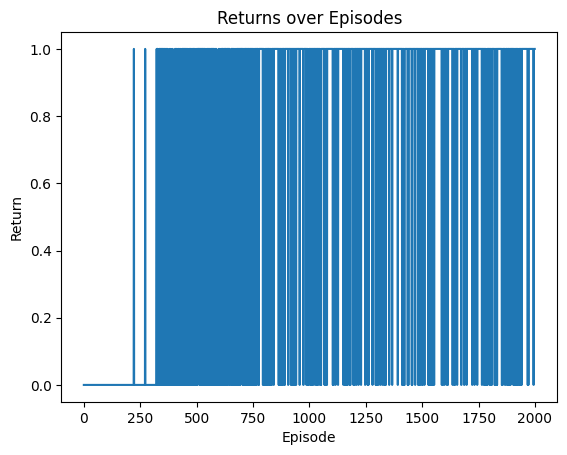

Rate of success:  0.64


In [36]:
f1.train(episodes=2000, render=False, is_slippery=False)

# Plot the returns
plt.plot(returns)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.title('Returns over Episodes')
plt.show()

print("Rate of success: ", sum(returns)/len(returns))

In [37]:
# Test the [policy_net] model
f1.test(episodes=10, render=True, is_slippery=False)

Episode 1/10
Goal reached!
Episode 2/10
Goal reached!
Episode 3/10
Goal reached!
Episode 4/10
Goal reached!
Episode 5/10
Goal reached!
Episode 6/10
Goal reached!
Episode 7/10
Goal reached!
Episode 8/10
Goal reached!
Episode 9/10
Goal reached!
Episode 10/10
Goal reached!


In conclusion, all three models trained on a large number of episodes always reach the target in the test. The best model turns out to be the DQN due to its ability to learn and estimate the optimal policy in a much smaller number of episodes and thus appears to be the most efficient one.